In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; }
.container {width:95% !important;}
</style>

#### <h1 style="text-align:center">Clase 13: Introducción a procesamiento y análisis de eventos sísmicos </h1>
<h3 style="text-align:center">ACUS125: Aislamiento y Análisis de Vibraciones</h3>
<p style="text-align:center">Dr. Víctor Poblete <br>
<a href="mailto:vpoblete@uach.cl">vpoblete@uach.cl</a><br>
<a href="https://github.com/vpobleteacustica/ACUS125-Aislamiento-y-Analisis-de-Vibraciones">https://github.com/vpobleteacustica/ACUS125-Aislamiento-y-Analisis-de-Vibraciones</a><br> 
<a href="http://www.acusticauach.cl">www.acusticauach.cl</a><br> 

### Importar módulos necesarios 

In [2]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.colors import LogNorm

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter

from __future__ import print_function
import scipy.io.wavfile as wavfile
import scipy
from scipy import signal
from scipy.signal import convolve
import scipy.fftpack
from scipy.fft import fft, ifft, fftfreq
from scipy.fftpack import rfft, irfft

from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import obspy.signal
import math

### Visualización formas de ondas y espectrogramas de eventos sísmicos ocurridos en Chile
+ [Seleccionemos el terremoto de Chile, M8.8, de Febrero 27 de 2010](http://www.adc1.iris.edu/ds/newsletter/vol12/no1/63/february-2010-m88-chile-quake/)

### Definir proveedor de datos: 
+ Para descargar la información sísmica debemos usar una fuente proveedora de datos. 
+ Seteamos IRIS como nuestro proveedor de datos: [IRIS](https://www.iris.edu/hq/).
+ Existen otros proveedores, [ver por ejemplo](https://docs.obspy.org/packages/obspy.clients.fdsn.html), 

In [3]:
client = Client(
   "IRIS"
)

### Seleccionar red:

+ Podemos seleccionar una red sísmica de la cual descargar los datos. 


In [4]:
net  = "C"     # código de red sismológica nacional: ver listado de redes en: http://ears.iris.washington.edu/networkList.html
sta  = "*"     # código de estación y seleccionamos todas las estaciones
loc  = "*"     # seleccionamos todas las locaciones disponibles para esa estacion
chan = "*"     # seleccionamos todas los canales

### Especificar el tiempo de ocurrencia del evento
+ El evento sísmico lo especificamos usando el rango de tiempo en que ocurre el evento. La librería Obspy usa tiempo universal [UTCDateTime](https://docs.obspy.org/tutorial/code_snippets/utc_date_time.html).
+ Definimos el tiempo del sismo, luego vamos a especificar tiempo de onset y tiempo de offset de las formas de onda que se descargarán.
+ Para ilustrar, definamos que queremos descargar formas de ondas desde 1 minuto antes del tiempo de onset y 15 minutos después del tiempo de offset.


In [5]:
tiempo_M8_8_Chile = "2010-02-27T06:34:17.000" 
eventTime         = UTCDateTime(tiempo_M8_8_Chile)
starttime         = eventTime - 60                   # 1 minuto antes del evento
endtime           = eventTime + 15 * 60                # 15 minutos después del evento

### Descargamos las formas de onda y las almacenamos en objetos tipo *Stream*
+ Un stream es un objeto tipo lista que contiene múltiples objetos tipo *Traza*.
+ Estas trazas son series de tiempo continuas y contienen información de *meta-data*


In [6]:
myStream = client.get_waveforms(net, sta, loc, chan, starttime, endtime)

### Listamos todas las trazas disponibles: 

In [7]:
print(myStream.__str__(extended = True)) 

15 Trace(s) in Stream:
C.CL2C..BHE   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.CL2C..BHN   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.CL2C..BHZ   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.NICH..SHE   | 2010-02-27T06:33:17.002900Z - 2010-02-27T06:37:04.231776Z | 50.0 Hz, 11362 samples
C.NICH..SHN   | 2010-02-27T06:33:17.002900Z - 2010-02-27T06:37:04.231776Z | 50.0 Hz, 11362 samples
C.NICH..SHZ   | 2010-02-27T06:33:17.002900Z - 2010-02-27T06:37:04.231776Z | 50.0 Hz, 11362 samples
C.PEL1..BHE   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.PEL1..BHN   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.PEL1..BHZ   | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 48001 samples
C.PSCH.00.SHE | 2010-02-27T06:33:17.000000Z - 2010-02-27T06:49:17.000000Z | 50.0 Hz, 4

### Guardamos en nuestro disco el dataset en formato SAC (Seismic Analysis Code): 

In [8]:
myStream.write('C_CL2C_BHZ.SAC', format = 'SAC')

### Leer un archivo SAC para analizar su información:

In [9]:
filename = 'C_CL2C_BHZ01.SAC'
my_st = read(filename, debug_headers = True)

### Meta-data de la traza: 

In [10]:
# Analizamos la traza 0.
print(my_st[0].stats)  #estadisticas

         network: C
         station: CL2C
        location: 
         channel: BHE
       starttime: 2010-02-27T06:33:17.000000Z
         endtime: 2010-02-27T06:49:17.000000Z
   sampling_rate: 50.0
           delta: 0.02
            npts: 48001
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.02, 'depmin': -8192000.0, 'depmax': 8173387.0, 'scale': 1.0, 'odelta': -12345.0, 'b': 0.0, 'e': 960.0, 'o': -12345.0, 'a': -12345.0, 'internal0': -12345.0, 't0': -12345.0, 't1': -12345.0, 't2': -12345.0, 't3': -12345.0, 't4': -12345.0, 't5': -12345.0, 't6': -12345.0, 't7': -12345.0, 't8': -12345.0, 't9': -12345.0, 'f': -12345.0, 'resp0': -12345.0, 'resp1': -12345.0, 'resp2': -12345.0, 'resp3': -12345.0, 'resp4': -12345.0, 'resp5': -12345.0, 'resp6': -12345.0, 'resp7': -12345.0, 'resp8': -12345.0, 'resp9': -12345.0, 'stla': -12345.0, 'stlo': -12345.0, 'stel': -12345.0, 'stdp': -12345.0, 'evla': -12345.0, 'evlo': -12345.0, 'evel': -12345.0, 'evdp': -12345.0, 'mag

### Plotear los datos: 

<IPython.core.display.Javascript object>


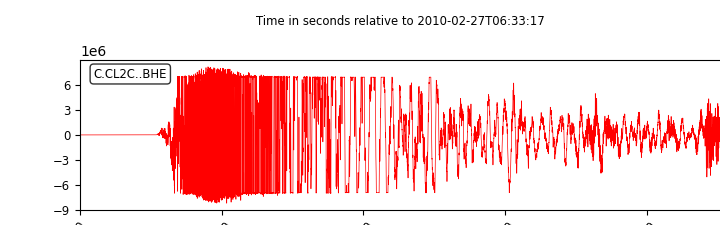

In [11]:
path_images = '/home/kasparov/Documentos/20190114_vpoblete/20210329_acus125_autumn2021/clase_13_eventos_sismicos/images/'
my_st.plot(
    outfile         = path_images + "my_st_relative.png",
    starttime       = None,
    endtime         = None,
    size            = (800, 250),
    dpi             = 100,
    color           = "red",
    bgcolor         = "white",
    face_color      = "white",
    transparent     = False,
    number_of_ticks = 6,
    tick_rotation   = 45,
    type            = "relative",
    linewidth       = 0.5,
    linestyle       = "-",
    
)

<IPython.core.display.Javascript object>


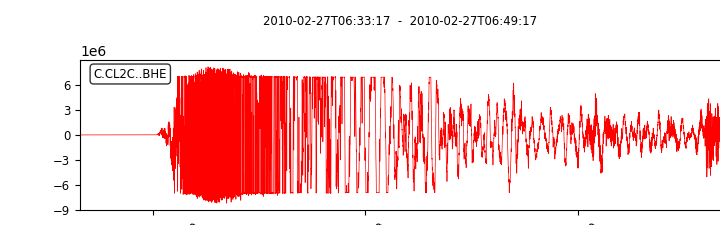

In [12]:
my_st.plot(
    outfile         = path_images+"my_st_normal.png",
    starttime       = None,
    endtime         = None,
    size            = (800, 250),
    dpi             = 100,
    color           = "red",
    bgcolor         = "white",
    face_color      = "white",
    transparent     = False,
    number_of_ticks = 6,
    tick_rotation   = 45,
    type            = "normal",
    linewidth       = 0.5,
    linestyle       = "-",
    
)

### Seleccionamos las muestras de la traza: 

<IPython.core.display.Javascript object>


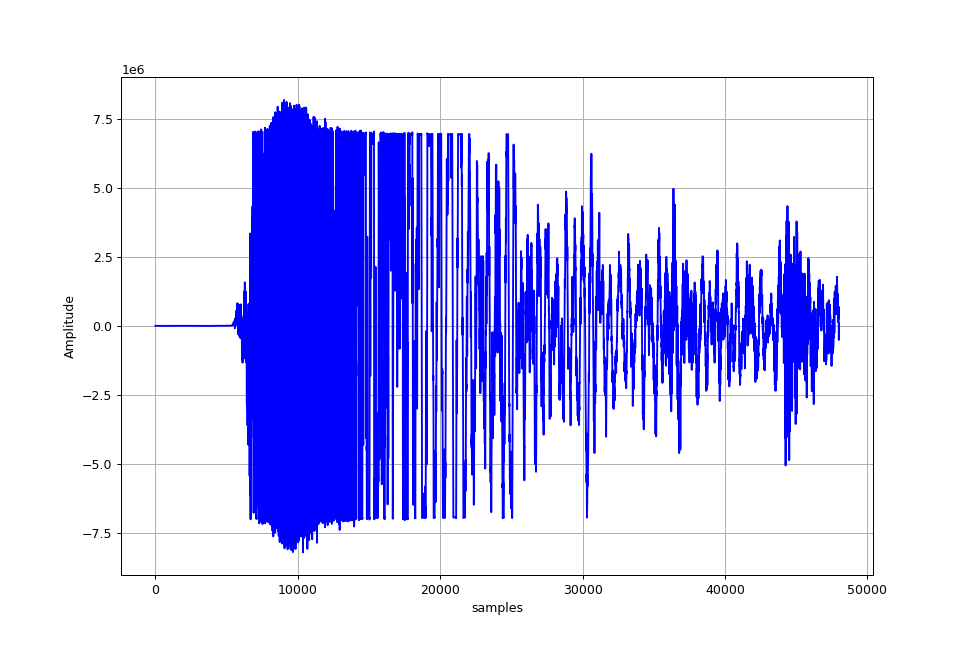

In [13]:
my_tr = my_st[0]
my_tr_samples = my_tr.data

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)

ax1.plot(my_tr_samples, "b") # plotting the positive fft spectrum
ax1.set_xlabel('samples')
ax1.set_ylabel('Amplitude')
ax1.grid()
plt.rcParams.update({'font.size': 12})

### Duración en tiempo de la traza: 

In [14]:
horas_chile = (my_tr.stats.endtime - my_tr.stats.starttime)/60
print('El archivo SAC leído tiene una duración de %d minutos' % (horas_chile))

El archivo SAC leído tiene una duración de 16 minutos


### Cambiar de muestras a segundos: 

<IPython.core.display.Javascript object>


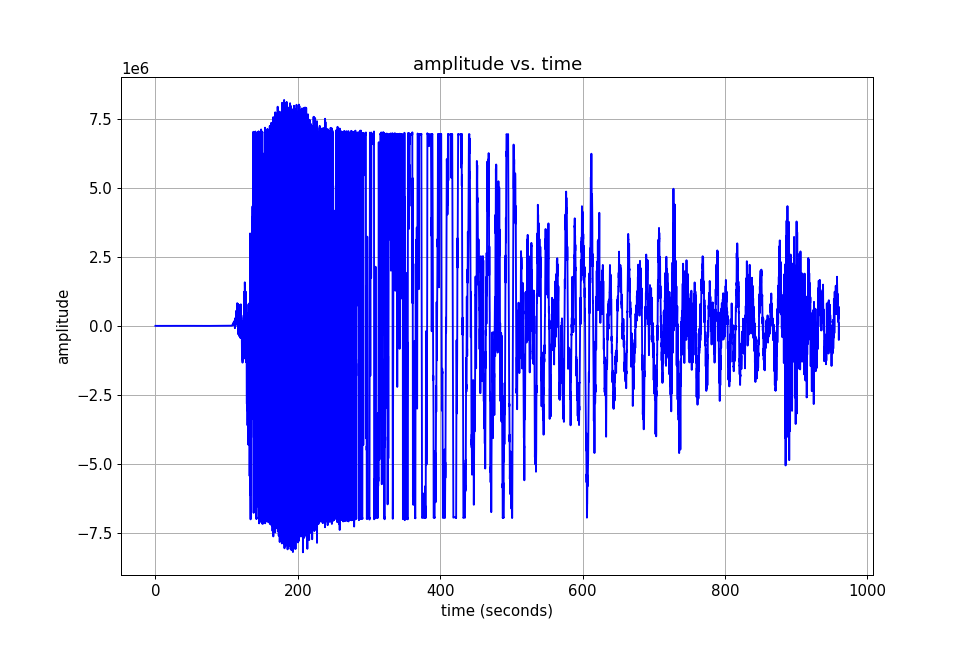

In [15]:
sr    = my_tr.stats.sampling_rate
largo = len(my_tr)                          # número total de muestras
t     = np.linspace(0, largo/sr, largo) 

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)

ax1.plot(t, my_tr, "b") # plotting the positive fft spectrum
plt.title('amplitude vs. time') 
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('amplitude')
ax1.grid()
plt.rcParams.update({'font.size': 12})


### Espectrograma de la traza 

<IPython.core.display.Javascript object>


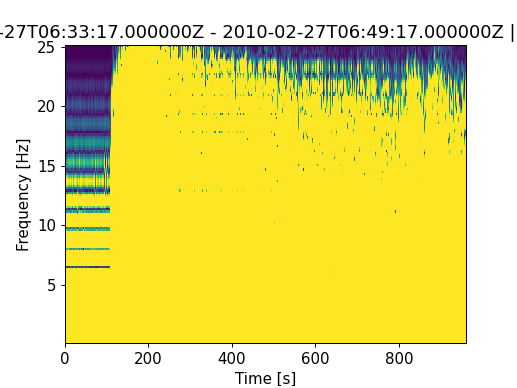

(0.0, 6479157.0547526451)


In [16]:
fig = my_tr.spectrogram(show=False)
ax  = fig.axes[0]
im  = ax.images[0]
print(im.get_clim())
im.set_clim(vmax = 100)
plt.show()

### Envolvente 

<IPython.core.display.Javascript object>


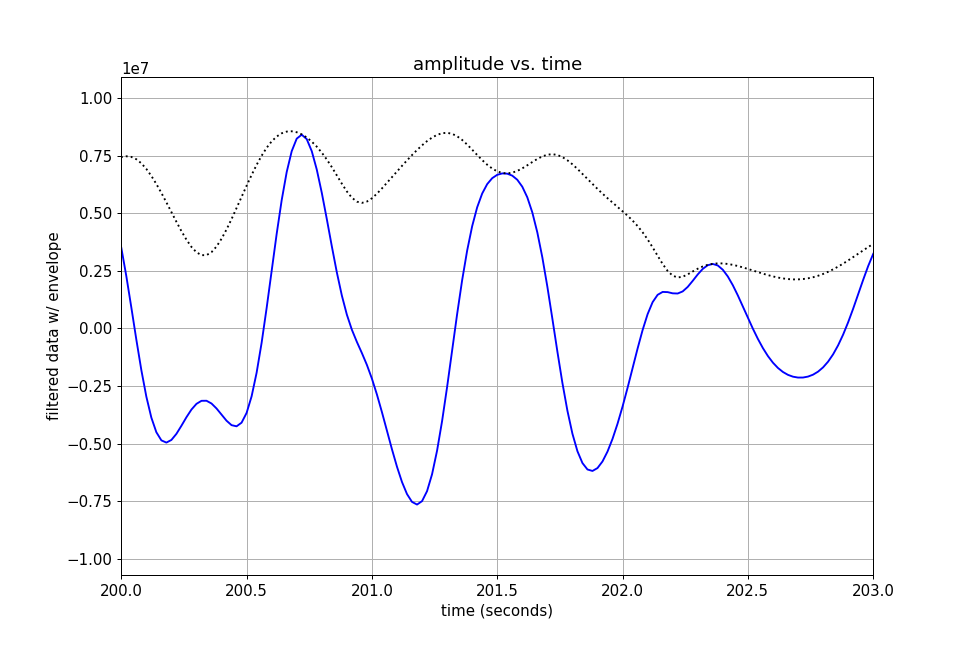

In [17]:
npts =  my_st[0].stats.npts
samprate = my_st[0].stats.sampling_rate

# Filtering the Stream object
myStream_filt = my_st.copy()

myStream_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(myStream_filt[0].data)


fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)

t = np.arange(0, npts / samprate, 1 / samprate)
ax1.plot(t, myStream_filt[0].data, 'b')
ax1.plot(t, data_envelope, 'k:')
plt.title(myStream[0].stats.starttime)
plt.xlim(200, 203)


#ax1.plot(t, my_tr, "b") # plotting the positive fft spectrum
plt.title('amplitude vs. time') 
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel('filtered data w/ envelope')
ax1.grid()
plt.rcParams.update({'font.size': 12})

### Información del evento:

In [18]:
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=8.8, catalog="ISC")

print(cat)


1 Event(s) in Catalog:
2010-02-27T06:34:13.330000Z | -36.148,  -72.933 | 8.8 MW


### Información de la estación

In [19]:
inventory = client.get_stations(network = net, station="*",
                                starttime=starttime,
                                endtime=endtime)
print(inventory)

Inventory created at 2021-06-07T17:50:21.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2010-02-27...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			C
		Stations (15):
			C.AGCH (Angol, Chile)
			C.ANTU (Antumapu)
			C.CHUE (Copihue, Chile)
			C.CL2C (Cerro Calan, Chile)
			C.CLCH (Cerro Calan)
			C.COYC (Coyhaique, Chile)
			C.FSR (Falla de San Ramon)
			C.IHA (Valparaiso, Chile)
			C.LACH (Colegio Las Americas, Santiago, Chile)
			C.NICH (Los Niches, Curico, Chile)
			C.PEL1 (Peldehue, Chile)
			C.PSCH (Chilean National Seismic Network)
			C.RCDM (CSN)
			C.SJCH (San Jose de Maipo, Chile)
			C.STL (Santa Lucia)
		Channels (0):



### Downsampling, filtrados y plotear espectrograma 

In [20]:
st_filtrado = my_st.copy()
st_filtrado.detrend(type = 'demean')
st_filtrado.detrend(type = 'linear')
st_filtrado.filter('highpass', freq = 8) 
st_filtrado.filter('lowpass', freq = 1)   
st_filtrado.decimate(2)
print(st_filtrado[0].stats) 
fs = st_filtrado[0].stats.sampling_rate

         network: C
         station: CL2C
        location: 
         channel: BHE
       starttime: 2010-02-27T06:33:17.000000Z
         endtime: 2010-02-27T06:49:17.000000Z
   sampling_rate: 25.0
           delta: 0.04
            npts: 24001
           calib: 1.0
         _format: SAC
      processing: ["ObsPy 1.2.2: detrend(options={}::type='demean')", "ObsPy 1.2.2: detrend(options={}::type='linear')", "ObsPy 1.2.2: filter(options={'freq': 8}::type='highpass')", "ObsPy 1.2.2: filter(options={'freq': 1}::type='lowpass')", "ObsPy 1.2.2: filter(options={'freq': 12.5, 'maxorder': 12}::type='lowpass_cheby_2')", 'ObsPy 1.2.2: decimate(factor=2::no_filter=False::strict_length=False)']
             sac: AttribDict({'delta': 0.02, 'depmin': -8192000.0, 'depmax': 8173387.0, 'scale': 1.0, 'odelta': -12345.0, 'b': 0.0, 'e': 960.0, 'o': -12345.0, 'a': -12345.0, 'internal0': -12345.0, 't0': -12345.0, 't1': -12345.0, 't2': -12345.0, 't3': -12345.0, 't4': -12345.0, 't5': -12345.0, 't6': -12345.0,

<IPython.core.display.Javascript object>


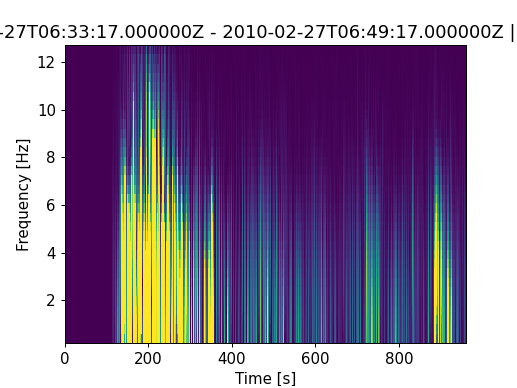

(1.1891944194880927e-08, 1043.7802487600841)


In [21]:
fig = st_filtrado[0].spectrogram(show=False)
ax  = fig.axes[0]
im  = ax.images[0]
print(im.get_clim())
im.set_clim(vmax = 100)
plt.show()

In [ ]:
print(len(my_tr_samples))

In [22]:
x           = my_tr_samples
x_max       = np.max(my_tr_samples)
x_norm      = x/x_max
winlength   = 2048
overlap     = 0.5
nhops       = math.floor((len(x_norm) - overlap*winlength)/(winlength-overlap*winlength)) 
x_mat       = np.zeros([nhops,winlength])
hop         = int(winlength*(1-overlap))#Salto de frame según overlap
for idx in range(nhops):
    j = hop*idx
    fila = []
    fila.append(x_norm[j:j+winlength])
    x_mat[idx] = fila[0]
    
E = []
for idx in range(nhops): 
    fila_sum = 0
    for n in range(winlength):
        fila_sum = ((x_mat[idx][n])**2)+fila_sum
        if n==winlength-1:
            E.append(fila_sum/winlength)
E    = E/(np.max(E))


Hanningwindow = np.zeros([1,winlength])
Hanningwindow[0] = np.hanning(winlength)
Hanningwindow = np.repeat(Hanningwindow,[nhops],axis=0)
x_mat_hanning = x_mat*Hanningwindow

Xaudio_mat = np.zeros([winlength, nhops], dtype = "complex_")
x_mat = np.transpose(x_mat_hanning)
for k in range(0, nhops):
    Xaudio_mat[:,k] = fft(x_mat[:,k])
MagXaudio_mat = np.abs(Xaudio_mat)
Xaudio_mat2 = np.power(MagXaudio_mat,2) 

In [23]:
Xaudio_mat = np.zeros([winlength, nhops], dtype = "complex_")
x_mat = np.transpose(x_mat_hanning)

for nf in range(0, nhops):
    Xaudio_mat[:,k] = fft(x_mat[:,k])

In [26]:
print(x_mat.shape)

(2048, 45)


In [24]:
def TF(s, fs):
    N = s.shape[0]
    #print('N is ', N)
    Ni = int(N/2)
    #print('Ni is', Ni)
    secs = N / float(fs)
    Ts = 1.0/fs                                         # sampling interval in time
    t = np.arange(0, secs, Ts)                          # time vector as scipy arange field / numpy.ndarray
    S = fft(s)
    S_mag = abs(fft(s))
    S_side = S[range(Ni)]                               # one side FFT range
    #print(S_side.shape)
    freqs = scipy.fftpack.fftfreq(s.size, t[1]-t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(Ni)]                       # one side frequency range
    fft_freqs_side = np.array(freqs_side)
    #return (t, freqs, freqs_side, S, S_mag, S_side)
    return (S)

def TF2(s, fs):
    N = s.shape[0]
    #print('N is ', N)
    Ni = int(N/2)
    #print('Ni is', Ni)
    secs = N / float(fs)
    Ts = 1.0/fs                                         # sampling interval in time
    t = np.arange(0, secs, Ts)                          # time vector as scipy arange field / numpy.ndarray
    S = fft(s)
    S_mag = abs(fft(s))
    S_side = S[range(Ni)]                               # one side FFT range
    #print(S_side.shape)
    freqs = scipy.fftpack.fftfreq(s.size, t[1]-t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(Ni)]                       # one side frequency range
    fft_freqs_side = np.array(freqs_side)
    #return (t, freqs, freqs_side, S, S_mag, S_side)
    return (freqs_side, S_side)

Xaudio_mat      = np.zeros([winlength, nhops], dtype = "complex_")
Xaudio_mat_side = np.zeros([int(winlength/2), nhops], dtype = "complex_")
freqs_side      = np.zeros([int(winlength/2), nhops], dtype = "complex_")
x_mat = np.transpose(x_mat_hanning)
for k in range(0, nhops):
    Xaudio_mat[:,k] = TF(x_mat[:,k], fs)
    
for l in range(0, nhops):
    freqs_side[:,l], Xaudio_mat_side[:,l] = TF2(x_mat[:,l], fs)

for m in range(0, nhops):
    Xaudio_mat_side[:,m] = Xaudio_mat_side[:,m]/max(Xaudio_mat_side[:,m])
      
MagXaudio_mat = np.abs(Xaudio_mat)
Xaudio_mat2 = np.power(MagXaudio_mat,2) 

magXaudio_mat_side = np.abs(Xaudio_mat_side)
mag2Xaudio_mat_side = np.power(magXaudio_mat_side,2)

In [25]:
print(mag2Xaudio_mat_side.shape)

(1024, 45)


In [ ]:
max_freq = freqs_side.max()
print(max_freq)

/home/kasparov/.local/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 45, using nperseg = 45
  warnings.warn('nperseg = {0:d} is greater than input length '


<IPython.core.display.Javascript object>


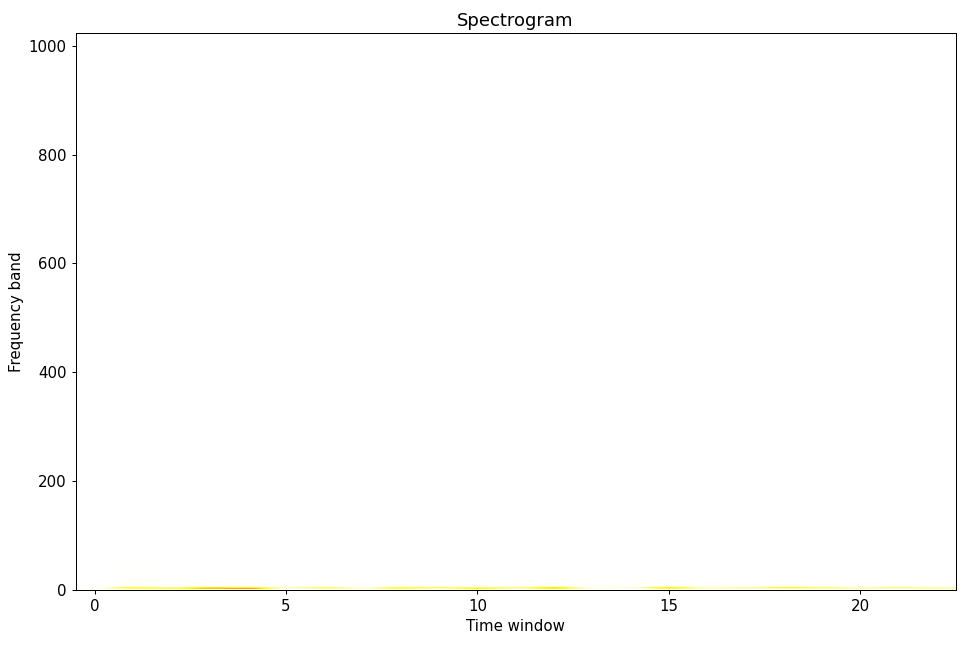

In [28]:
freqs, times, spectrogram = signal.spectrogram(mag2Xaudio_mat_side, fs=fs)

plt.figure(figsize=(12, 8))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

<IPython.core.display.Javascript object>


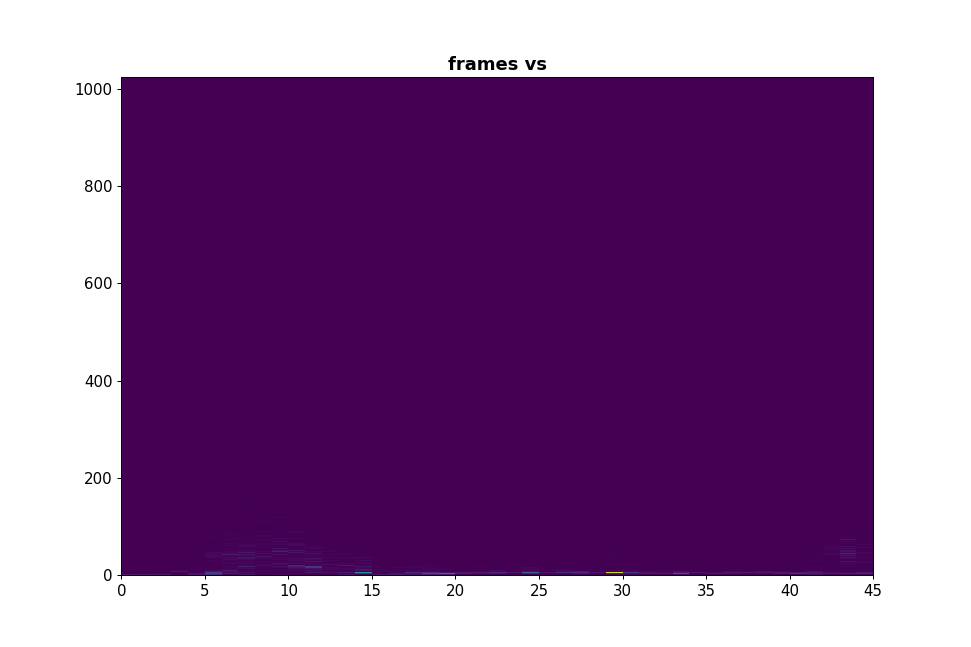

In [29]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)
Z = mag2Xaudio_mat_side
     
plt.pcolormesh(Z)
  
plt.title('frames vs', fontweight ="bold")
plt.show()

In [ ]:
print((mag2Xaudio_mat_side[0][0:2]))

In [ ]:
print(Xaudio_mat_side.shape)

<IPython.core.display.Javascript object>


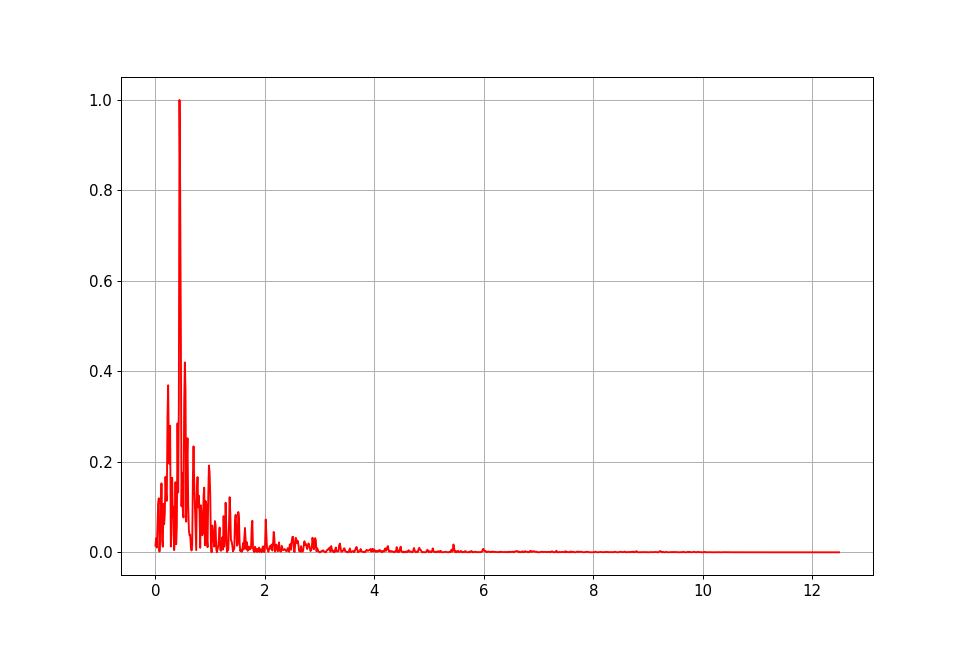

In [30]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)

ax1.plot(np.real(freqs_side[:,0]), mag2Xaudio_mat_side[:,8], 'r')
#ax1.plot(x_mat_hanning[28,:], 'g')
#ax1.set_xlim(0, 2)
#plt.title('amplitude vs. time') 
#ax1.set_xlabel('time (seconds)')
#ax1.set_ylabel('filtered data w/ envelope')
ax1.grid()
plt.rcParams.update({'font.size': 12})

In [ ]:
print(MagXaudio_mat.shape)

<IPython.core.display.Javascript object>


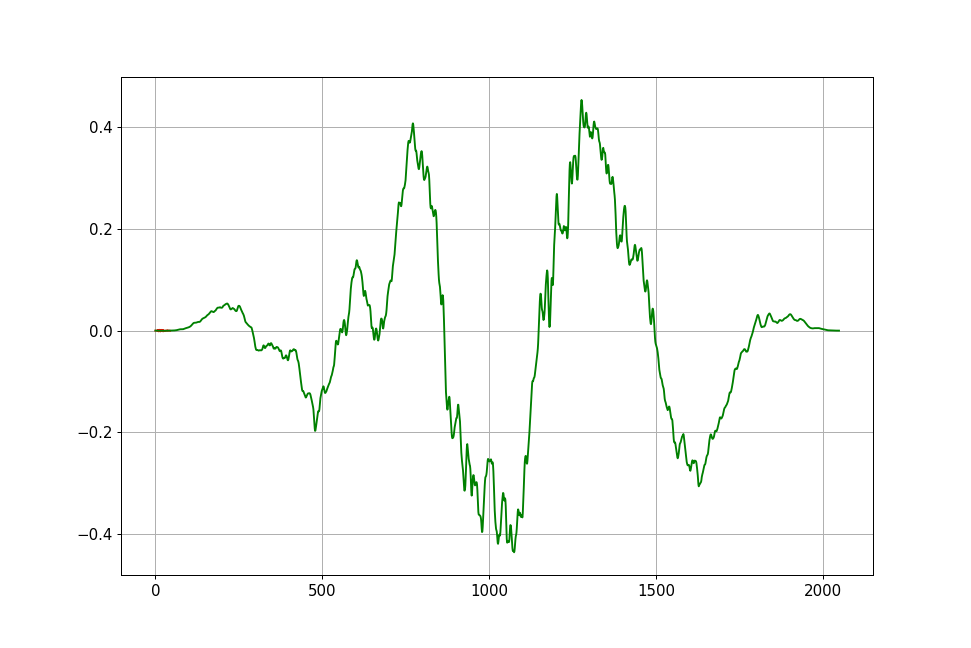

In [31]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8)) 
fig.subplots_adjust(hspace=.75)

ax1.plot(x_mat[28,:], 'r')
ax1.plot(x_mat_hanning[28,:], 'g')

#plt.title('amplitude vs. time') 
#ax1.set_xlabel('time (seconds)')
#ax1.set_ylabel('filtered data w/ envelope')
ax1.grid()
plt.rcParams.update({'font.size': 12})